In [5]:
%load_ext autoreload
%autoreload 2

from wb_api_wrapper import *

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from IPython.display import display, HTML

import matplotlib.pyplot as plt 
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#Pandas display options
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', 200)
pd.set_option('display.precision', 4)
pd.set_option('display.max_rows', 200)

In [7]:
#Options for plots
font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 12}

plt.rc('font', **font)
plt.rcParams["legend.fancybox"]=True
plt.rcParams["savefig.dpi"]=90

plot_options = dict(alpha=0.5)

def format_fig(ax):
    ax.set_xlim(0)
    ax.set_ylim(0)

In [8]:
#Searching the WB API database

search_wb("GDP");
search_wb("emissions");

# Data

### Pop and gdp

In [9]:
#gdp_pc_ppp  = get_wb("NY.GNP.PCAP.PP.CD") if gni else get_wb("NY.GDP.PCAP.PP.CD")#GDP per capita, PPP (constant 2011 international $)
gdp = get_wb("NY.GDP.MKTP.PP.KD")#GGDP, PPP (constant 2011 international $)
pop = get_wb("SP.POP.TOTL") #populationb

gdp_pc_ppp=gdp/pop

### Emissions

In [10]:
emis_tot = get_wb("EN.ATM.CO2E.KT")*1000 #emissions in tons
#Both series end in 2011

emis_intens = emis_tot /gdp 
emis_pc = emis_tot/pop

###Dataframe

In [11]:
df=pd.DataFrame()
df["emis_intens"]=emis_intens.stack()
df["gdp_pc"] = gdp_pc_ppp.stack()
df["pop"] = pop.stack()
df["emis_tot"] = emis_tot.stack()

df["emis_pc"]= emis_pc.stack()


#Income gorups for countries and HIPC status
groups = pd.read_csv("counry_income_groups.csv",header =4,index_col=2).replace({"ROM":"ROU","ZAR":"COD"})  #they used old iso3 country for Zair (Congo) and Romania
groups.dropna(axis=0,how="all",inplace=True);

df= df.ix[groups.index] #keeps only actula countries (no macro regions or groups of countries)

data_all = df.reset_index()

#income bins
bins = [0]+ data_all.gdp_pc.quantile([.2,.4,.6,.8,1]).tolist()
bins = [0]+ data_all.gdp_pc.quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,1]).tolist()
bins[-1]=1e7 #"makes sure the last bins covers future incomes"
print("income bins", bins)


data_all["income_bins"] = pd.cut(data_all.gdp_pc,bins);



income bins [0, 1406.4334773738788, 2306.1859942792667, 4057.0886270776869, 6413.4570457119662, 9176.798702728116, 12418.041232104768, 17800.033169427625, 27906.491124886128, 41449.72881262521, 10000000.0]


In [12]:
#Current emissions
emis_ref = data_all.dropna().query("year=='2011'").emis_tot.sum()
print("Global CO2 emissions in the sample: {emis:0.0f} GtCO2".format(emis=emis_ref*1e-9))

Global CO2 emissions in the sample: 32 GtCO2


## Lorenz curve

In [13]:
lending_group =pd.read_excel("CLASS.xls", skiprows=4, index_col="Economy", usecols=["Economy","Lending category"]).dropna(how="all").dropna(how="all",axis=1).squeeze()

In [17]:
#SPECILA TREATEMENT FOR INDIA
lending_group["India"]="Blend"

In [18]:
lending_group.unique()
colors = {
    'IDA':"#d7301f", 'IBRD':"#67a9cf", '..':"#f7f7f7", 'Blend':"#af8dc3"
}
edgecolors = {
    'IDA':"#ff0000", 'IBRD':"#053061", '..':"#4d4d4d", 'Blend':"#7b3294"
}


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


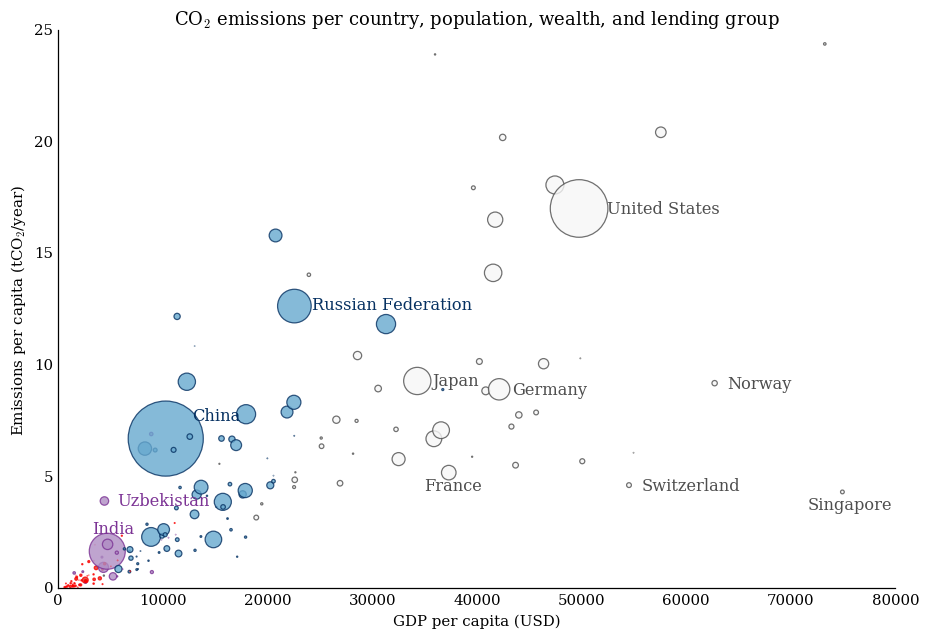

In [19]:
dsimple = data_all.query("year=='2011'")[["country","pop","gdp_pc","emis_tot","emis_pc"]].sort("gdp_pc")

dsimple["country_color"] = dsimple.country.replace(lending_group.replace(colors))

names_=dsimple["country"]
logical=names_.isin(["United States","India","China","Russian Federation", "Uzbekistan",
                    "Japan","Germany","Switzerland" , "Norway", "Singapore", "France"]) 
#+ names_.replace(lending_group).isin(["Blend"])

dsimple.to_excel("fig6.3_not_cumulative__.xlsx")

plt.figure(figsize=(12,8))
x=dsimple["gdp_pc"]
y=dsimple["emis_pc"]
plt.scatter(x,y, s=2*dsimple["emis_tot"]/5e6, alpha=0.8, 
            c=dsimple.country.replace(lending_group.replace(colors)), 
            edgecolors=dsimple.country.replace(lending_group.replace(edgecolors)))
plt.xlim(0,80000)
plt.ylim(0,30)


offsets ={
    "United States":(22,0),"India":(-12,18),"China":(21,18),
    "Russian Federation":(14,1), "Uzbekistan":(10,0),
    "Japan":(12,0),"Germany":(10,0),"France":(-20, -10),
    "Switzerland":(10,0) ,"Kuwait":(-25,-10),
    "Norway":(10,0), "Singapore":(-28,-10)
}
ax=plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_ylim(ymax=25)

#removes ticks 
for tic in ax.yaxis.get_major_ticks()+ax.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

if (logical is not None) :
    for label, x_, y_ in zip(names_[logical], x[logical], y[logical]):
        plt.annotate(
            label, 
            xy = (x_, y_), xytext = offsets[label],
            textcoords = 'offset points', ha = 'left', va = 'center',fontsize=13, color =edgecolors[lending_group[label]]
            #bbox = nonedict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            #arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0')
        )

         
#plt.scatter(x.iloc[0:40],y.iloc[0:40], s=dsimple["emis_tot"].iloc[0:40]/5e6, clip_on=False, color="red",alpha=1)
plt.title("CO$_2$ emissions per country, population, wealth, and lending group")     
        
plt.xlabel("GDP per capita (USD)")
plt.ylabel("Emissions per capita (tCO$_2$/year)")

plt.savefig("scatter_natgeo.png")

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


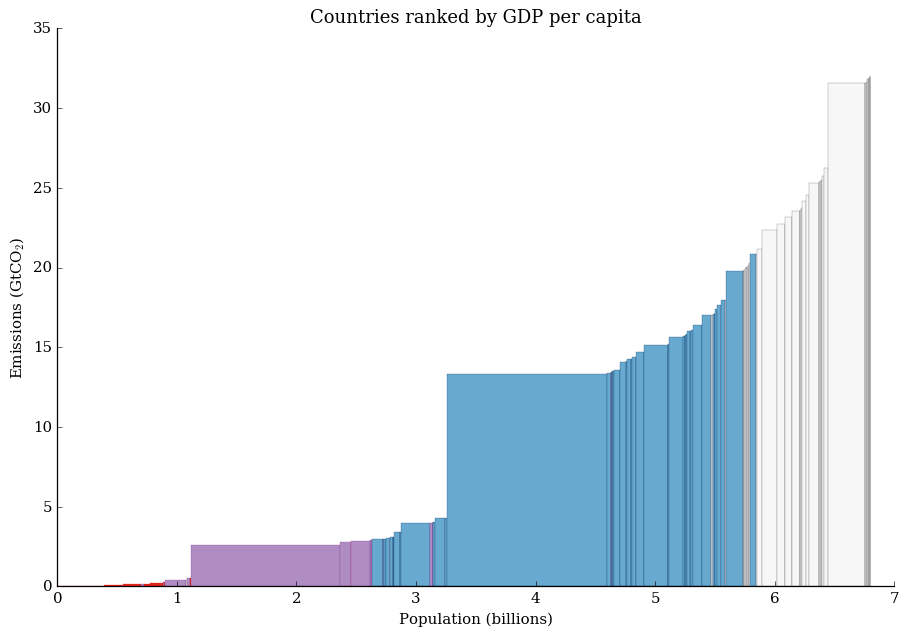

In [20]:
dflor = data_all.query("year=='2011'")[["country","pop","gdp_pc","emis_tot"]].sort("gdp_pc")
dflor[["pop","emis_tot"]]=dflor[["pop","emis_tot"]]/1e9
dflor["cum_emis"]=dflor.emis_tot.cumsum()
dflor["cum_pop"]=[0]+dflor["pop"][:-1].cumsum().tolist()
#dflor["cum_pop"]-=dflor["cum_pop"].iloc[0] #offset x axis
#dflor.plot(x="cum_pop",y="cum_emis")


plt.figure(figsize=(12,8))
ax=plt.subplot(1,1,1)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

ax.bar(dflor.cum_pop, dflor.cum_emis, width=dflor["pop"], linewidth=0.2, color=dsimple.country.replace(lending_group.replace(colors)), 
            edgecolor=dsimple.country.replace(lending_group.replace(edgecolors)))


ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel("Population (billions)")
plt.ylabel('Emissions (GtCO$_2$)')

title = "Countries ranked by GDP per capita"

plt.title(title)


plt.savefig("lorentz_2011_step.png")

plt.savefig("lorentz_2011_step.eps")
dflor[["country","cum_pop","cum_emis"]].set_index("country").to_csv("lorentz_2011_step.csv", index=True)



C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


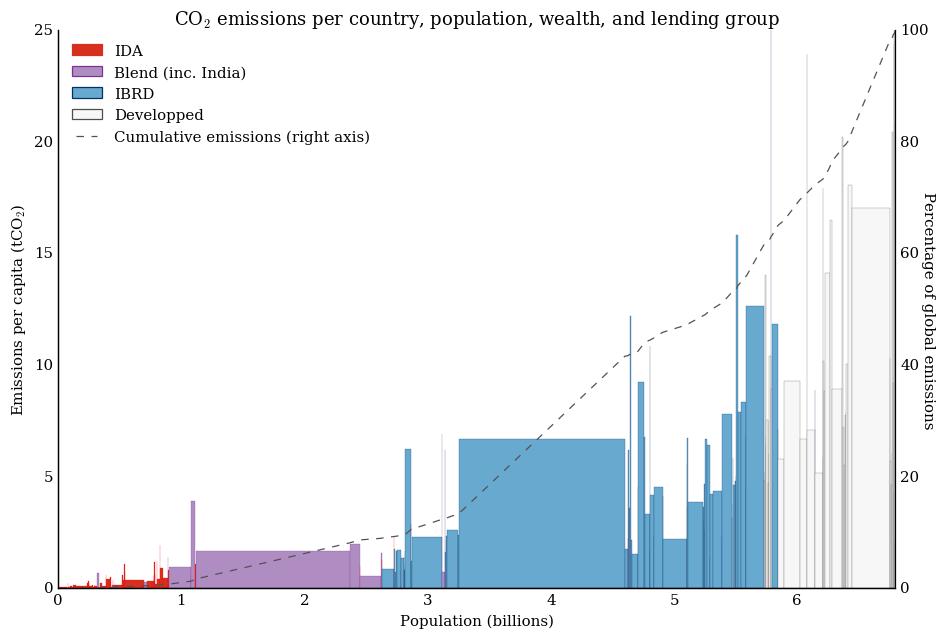

In [51]:
dflor = data_all.query("year=='2011'")[["country","pop","gdp_pc","emis_tot","emis_pc"]].sort("gdp_pc")
dflor[["pop","emis_tot"]]=dflor[["pop","emis_tot"]]/1e9
dflor["cum_emis"]=100*dflor.emis_tot.cumsum()/dflor.emis_tot.cumsum().iloc[-1]
dflor["cum_pop"]=[0]+dflor["pop"][:-1].cumsum().tolist()

dflor["cum_pop2"]=dflor["pop"].cumsum()
#dflor["cum_pop"]-=dflor["cum_pop"].iloc[0] #offset x axis
#dflor.plot(x="cum_pop",y="cum_emis")
plt.figure(figsize=(12,8))

ax=plt.subplot(1,1,1)




ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

ax.bar(dflor.cum_pop, dflor.emis_pc, width=dflor["pop"], linewidth=0.2, color=dsimple.country.replace(lending_group.replace(colors)), 
            edgecolor=dsimple.country.replace(lending_group.replace(edgecolors)))


ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel("Population (billions)")
plt.ylabel('Emissions per capita (tCO$_2$)')


ax2=ax.twinx()
ax2.plot(dflor.cum_pop2, dflor.cum_emis, "--", color="#525252")
ax2.set_ylabel("Percentage of global emissions", rotation=-90)

ax.spines['top'].set_color('none')
ax.set_ylim(ymax=25)
ax2.spines['top'].set_color('none')

title = "CO$_2$ emissions per country, population, wealth, and lending group"

for tic in ax2.yaxis.get_major_ticks()+ax.yaxis.get_major_ticks()+ax.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

plt.title(title)

plt.xlim(xmax=dflor["pop"].sum())



if False:
    #Get artists and labels for legend and chose which ones to display
    handles, labels = ax.get_legend_handles_labels()
    display = (0,1,2)

    #Create custom artists
    simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
    anyArtist = plt.Line2D((0,1),(0,0), color='k')

    #Create legend from custom artist/label lists
    ax.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
              [label for i,label in enumerate(labels) if i in display]+['Simulation', 'Analytic'])


    cols = [colors['IDA'],colors['Blend'], colors['IBRD'], colors['..']]

    labels = ['IDA','Blend' , 'IBRD', 'Developped']
    dummies = [ax.plot([], [], ls='-', c=c)[0] for c in cols]        
    ax.legend(dummies, labels)


    
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

patchs=[
    mpatches.Patch(ec=colors['IDA'],  fc=colors['IDA'], label='IDA'),
    mpatches.Patch(ec=edgecolors['Blend'],fc=colors['Blend'], label='Blend (inc. India)'),
    mpatches.Patch(ec=edgecolors['IBRD'], fc=colors['IBRD'], label='IBRD'),
    mpatches.Patch(ec=edgecolors['..'],   fc=colors['..'], label='Developped'),
    mlines.Line2D([], [], ls="--", color='#525252', label='Cumulative emissions (right axis)')
         ]

ax.legend(handles=patchs, loc="upper left", prop=font,frameon=False)    


plt.savefig(title+".png")

plt.savefig(title+".eps")
dflor[["country","cum_pop","cum_emis"]].set_index("country").to_csv(title+".csv", index=True)




C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


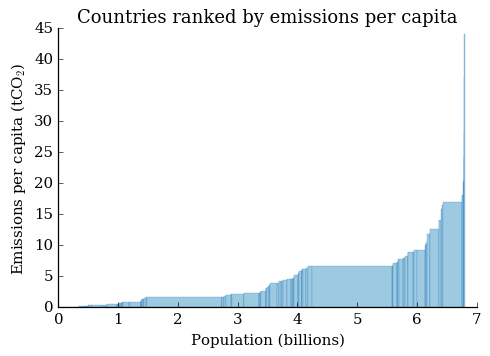

In [22]:
dflor = data_all.query("year=='2011'")[["country","pop","gdp_pc","emis_tot","emis_pc"]].sort("emis_pc")
dflor[["pop","emis_tot"]]=dflor[["pop","emis_tot"]]/1e9
dflor["cum_emis"]=dflor.emis_tot.cumsum()
dflor["cum_pop"]=[0]+dflor["pop"][:-1].cumsum().tolist()
#dflor["cum_pop"]-=dflor["cum_pop"].iloc[0] #offset x axis
#dflor.plot(x="cum_pop",y="cum_emis")


ax=plt.subplot(1,1,1)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

ax.bar(dflor.cum_pop, dflor.emis_pc, width=dflor["pop"], linewidth=0.2, color = "#9ecae1", edgecolor="#3182bd")


ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel("Population (billions)")
plt.ylabel('Emissions per capita (tCO$_2$)')

title = "Countries ranked by emissions per capita"



plt.title(title)

plt.savefig(title+".png", dpi=600)

plt.savefig(title+".eps")
dflor[["country","cum_pop","cum_emis"]].set_index("country").to_csv(title+".csv", index=True)



In [13]:
(dflor["emis_pc"]*dflor["pop"]).sum()

32.062319158

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


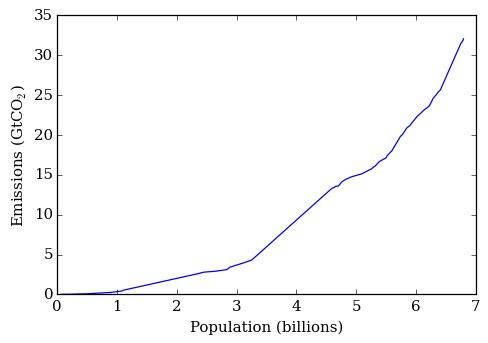

In [14]:
dflor = data_all.query("year=='2011'")[["country","pop","gdp_pc","emis_tot"]].sort("gdp_pc")
dflor["cum_emis"]=dflor.emis_tot.cumsum()
dflor["cum_pop"]=dflor["pop"].cumsum()
#dflor.plot(x="cum_pop",y="cum_emis")

plt.xlabel("Population (billions)")
plt.ylabel('Emissions (GtCO$_2$)')
plt.plot(dflor.cum_pop/1e9, dflor.cum_emis/1e9)
plt.savefig("lorentz_2011_lisse.png")

plt.savefig("lorentz_2011_lisse.eps")
dflor[["cum_pop","cum_emis"]].to_csv("lorentz_2011_lisse.csv", index=False)

In [15]:
#What ending povety means
target_gdp_pc = 4230

#Emissions in LICs today
data2011= data_all.query("year=='2011'").copy()
LICs = data2011.ix[data2011.gdp_pc<target_gdp_pc].index
print("emissions in the LICs in 2011: {x:.2%}".format(x=data2011.ix[LICs].emis_tot.sum()/emis_ref))

print("population in the LICs in 2011: {x}".format(x=data2011.ix[LICs]["pop"].sum()))
print("population in the LICs in 2011: {x:.2%}".format(x=data2011.ix[LICs]["pop"].sum()/data2011["pop"].sum()))

#Countries with low income
country_lics = data2011.ix[LICs].country.tolist()
print(country_lics)
data2011.ix[LICs].country.to_csv( "countries_below_4000.txt", index=False, header="country")
len(LICs)


emissions in the LICs in 2011: 0.77%
population in the LICs in 2011: 896763829.0
population in the LICs in 2011: 13.19%
['Afghanistan', 'Bangladesh', 'Benin', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Djibouti', 'Eritrea', 'Ethiopia', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Kenya', 'Kiribati', 'Kyrgyz Republic', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Marshall Islands', 'Mauritania', 'Micronesia, Fed. Sts.', 'Moldova', 'Mozambique', 'Nepal', 'Nicaragua', 'Niger', 'Papua New Guinea', 'Rwanda', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'Sudan', 'Tajikistan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Vanuatu', 'Yemen, Rep.', 'Zambia', 'Zimbabwe']


50

In [16]:
data2011.query("gdp_pc<4000")["emis_tot"].sum()*1e-9

0.237867289

In [17]:
data2011.query("gdp_pc<4000")["pop"].sum()*1e-9

0.887396056

In [18]:
100* data2011.query("gdp_pc<4000")["emis_tot"].sum()/data2011["emis_tot"].sum()

0.7418904659635289

In [19]:
100* data2011.query("gdp_pc<4000")["pop"].sum()/data2011["pop"].sum()

13.056659762813595

In [20]:
100* data2011.query("gdp_pc<4000")["emis_tot"].sum()/data2011["emis_tot"].sum()/( data2011.query("gdp_pc<4000")["pop"].sum()/data2011["pop"].sum())

5.682084694253058

In [21]:
100* data2011.query("gdp_pc<2500")["emis_tot"].sum()/data2011["emis_tot"].sum()

0.2972273949690935

In [22]:
data2011.query("gdp_pc<2500")["pop"].sum()*1e-9

0.545995648

# Past relation between emissions and GDP

C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


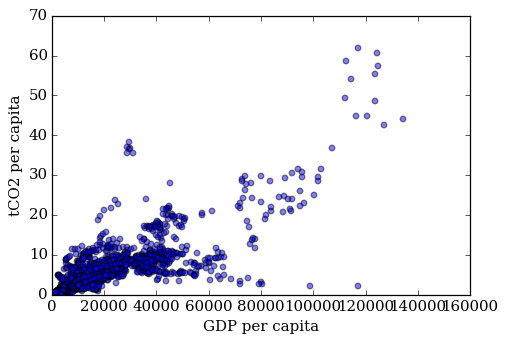

In [23]:
fig, ax = plt.subplots(1,1)
ax.scatter(data_all.gdp_pc,data_all.emis_pc,**plot_options)
ax.set_xlabel('GDP per capita')
ax.set_ylabel('tCO2 per capita')
format_fig(ax)
plt.savefig("emissions_vs_gdp.png")

C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


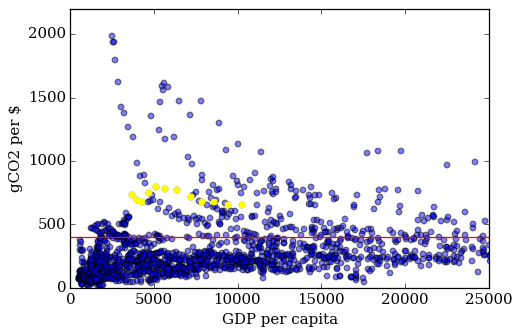

In [24]:
fig, ax = plt.subplots(1,1)
ax.scatter(data_all.gdp_pc,data_all.emis_intens*1e6,**plot_options)
ax.set_xlabel('GDP per capita')
ax.set_ylabel('gCO2 per $')
format_fig(ax)
ax.set_ylim(ymax=2.2e3)
ax.set_xlim(xmax=25e3)

plt.plot([0,25e3],[400,400],color="red")

ax.scatter(data_all.query("country=='China'").gdp_pc,data_all.query("country=='China'").emis_intens*1e6,color="yellow")

plt.savefig("paf.png")

In [25]:
data_all.query("emis_intens>800e-6");

### Population and GDP from SSP

In [26]:
gdp_proj = pd.read_csv(
    "gdp_ssp.csv",index_col="country", dtype={"scenario":str}).query("scenario=='SSP5'").drop("scenario",axis=1).sort_index()

In [27]:
pop_proj =1e6*pd.read_csv(
    "population_ssp.csv", index_col="country", dtype={"scenario":str}).query("scenario=='SSP5'").drop("scenario",axis=1).sort_index();


In [28]:
gdp_pc_proj = 1e9*gdp_proj/pop_proj

In [29]:
#Countries with low income
country_lics = data2011.ix[LICs].country.tolist()
print(country_lics)
data2011.ix[LICs].country.to_csv( "countries_below_4000.txt", index=False, header="country")

['Afghanistan', 'Bangladesh', 'Benin', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Djibouti', 'Eritrea', 'Ethiopia', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Kenya', 'Kiribati', 'Kyrgyz Republic', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Marshall Islands', 'Mauritania', 'Micronesia, Fed. Sts.', 'Moldova', 'Mozambique', 'Nepal', 'Nicaragua', 'Niger', 'Papua New Guinea', 'Rwanda', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'Sudan', 'Tajikistan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Vanuatu', 'Yemen, Rep.', 'Zambia', 'Zimbabwe']


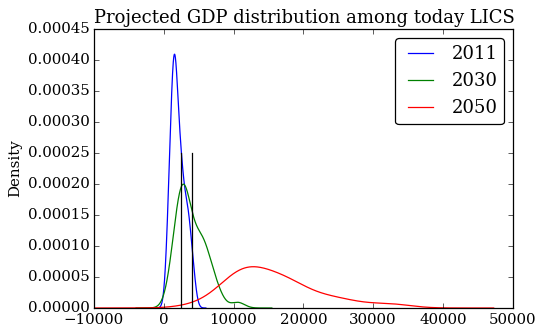

In [30]:
data2011.ix[LICs,"gdp_pc"].plot(kind="kde")
gdp_pc_proj.ix[country_lics,"2030"].plot(kind="kde")
gdp_pc_proj.ix[country_lics,"2050"].plot(kind="kde")
plt.legend(["2011","2030","2050"])
plt.plot([4000, 4000],[0, 25*1e-5],color="black")
plt.plot([2500, 2500],[0, 25*1e-5],color="black")

plt.title("Projected GDP distribution among today LICS")

In [31]:
data2011.query("10e3<gdp_pc<20e3").emis_tot.sum()/data2011.query("10e3<gdp_pc<20e3")["pop"].sum()

5.591948486145628

(0.80    338.5758
 0.85    400.0197
 0.90    496.8464
 0.91    508.2207
 Name: emis_intens, dtype: float64, 247.01035442656078)

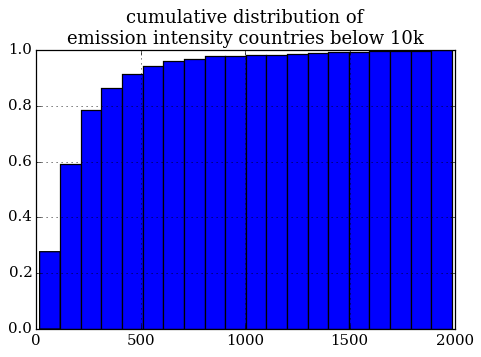

In [32]:
hop=(1e6*data_all.query("gdp_pc<10e3")["emis_intens"])
hop.hist(cumulative='True',normed=True,bins=20)
plt.xlabel("")
plt.ylim(ymax=1)
plt.title("cumulative distribution of \nemission intensity countries below 10k" )
hop.quantile([0.80,0.85,0.90,0.91]),hop.mean()


(0.80    384.5501
 0.81    392.5175
 0.82    400.8306
 0.83    411.2061
 0.85    429.2985
 0.90    510.7031
 Name: emis_intens, dtype: float64, 279.72935420034406)

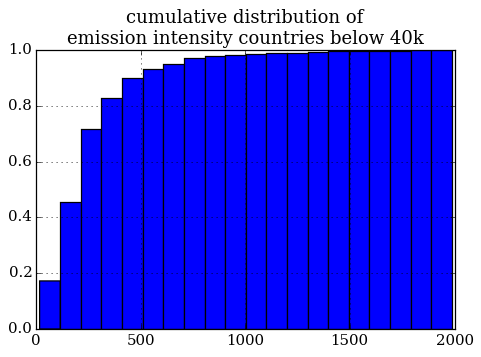

In [33]:
hop=(1e6*data_all.query("gdp_pc<40e3")["emis_intens"])
hop.hist(cumulative='True',normed=True,bins=20)
plt.title("cumulative distribution of \nemission intensity countries below 40k" )
hop.quantile([0.8,.81,.82,.83,0.85,0.9]), hop.mean()

# Simple projections

In [34]:
!cat rcp26.csv  #Emissions RCP are in GtC

years,RCP 26
"2030",7.157
"2035",5.846
"2040",4.535
"2045",3.8605
"2050",3.186


cat: #Emissions: No such file or directory
cat: RCP: No such file or directory
cat: are: No such file or directory
cat: in: No such file or directory
cat: GtC: No such file or directory


In [35]:
emis_rcp=pd.read_csv("rcp26.csv",  dtype={'years': object}).set_index('years').squeeze()* 1e9*44/12  #converts to tCO2
mis_rcp*1e-9 #RCP in GtCO2

NameError: name 'mis_rcp' is not defined

In [ ]:
data2011.emis_tot.sum()* 1e-9  #emissions in my data are in tCO2 as well
#http://www.epa.gov/climatechange/ghgemissions/global.html this page shows current emissions are about 30GtCO2

In [ ]:
inc_tresh_list = [1000, 2500, 4000, 4250, 4500, 4750, 5000, 6000]
inc_tresh_list = [ 4000]
for income_tresh in inc_tresh_list:
    countries = data2011.query("gdp_pc<"+str(income_tresh)).country
    em_intens = 800*1e-6

    emis_proj  = (gdp_proj.ix[countries]*em_intens*1e9).sum()
    years_proj = emis_proj.index.map(eval)

    years_to_plot = [2011]+years_proj.tolist()
    emis_proj_to_plot = [data2011.query("gdp_pc<"+str(income_tresh)).emis_tot.sum()]+emis_proj.tolist()
       

    rcp_to_plot = [data2011.emis_tot.sum()]+emis_rcp.tolist()

    plt.plot( years_to_plot,  100*np.array(emis_proj_to_plot)/np.array(rcp_to_plot) )
    
plt.ylabel("Share of CO$_2$ emissions \nconsistent with 2°C target (%)")
plt.legend(inc_tresh_list,loc="upper left")   
plt.ylim(ymax=100)


list(map(lambda x: x*1e-9,emis_proj_to_plot))

In [ ]:
data2011.query("gdp_pc<"+str(income_tresh)).emis_tot.sum()*1e-9

In [ ]:
inc_tresh_list = [1000, 2500, 4000,  5000]
#inc_tresh_list = [ 4000]
for income_tresh in inc_tresh_list:
    countries = data2011.query("gdp_pc<"+str(income_tresh)).country
    em_intens = 400*1e-6

    emis_proj  = (gdp_proj.ix[countries]*em_intens*1e9).sum()
    years_proj = emis_proj.index.map(eval)

    years_to_plot = [2011]+years_proj.tolist()
    emis_proj_to_plot = [data2011.query("gdp_pc<"+str(income_tresh)).emis_tot.sum()]+emis_proj.tolist()
    
    pop_proj_to_plot = [data2011.query("gdp_pc<"+str(income_tresh))["pop"].sum()]+pop_proj.ix[countries].sum().tolist()
    
    pop_tot_to_plot = [data2011["pop"].sum()]+pop_proj.sum().tolist()

    rcp_to_plot = [data2011.emis_tot.sum()]+emis_rcp.tolist()

    plt.plot( years_to_plot,  100*np.array(emis_proj_to_plot) * np.array(pop_tot_to_plot)/(np.array(pop_proj_to_plot)*np.array(rcp_to_plot) ))
    
plt.ylabel("Share of CO$_2$ emissions PER CAP \nconsistent with 2°C target (%)")
plt.legend(inc_tresh_list,loc="upper left")   
plt.ylim(ymax=100)

100*np.array(emis_proj_to_plot) * np.array(pop_tot_to_plot)/(np.array(pop_proj_to_plot)*np.array(rcp_to_plot) )

In [ ]:
inc_tresh_list = [1000, 2500, 4000, 4250, 4500, 4750, 5000, 6000]
inc_tresh_list = [ 4000]
for income_tresh in inc_tresh_list:
    countries = data2011.query("gdp_pc<"+str(income_tresh)).country
    em_intens = 800*1e-6

    emis_proj  = (gdp_proj.ix[countries]*em_intens*1e9).sum()
    years_proj = emis_proj.index.map(eval)

    years_to_plot = [2011]+years_proj.tolist()
    emis_proj_to_plot = [data2011.query("gdp_pc<"+str(income_tresh)).emis_tot.sum()]+emis_proj.tolist()
    
    

    rcp_to_plot = [data2011.emis_tot.sum()]+emis_rcp.tolist()

    plt.plot( years_to_plot,  1e-9*np.array(emis_proj_to_plot) )
    
plt.ylabel("CO$_2$ emissions (GtCO2)")
plt.legend(inc_tresh_list,loc="upper left")   


In [ ]:
inc_tresh_list = [1000, 2500, 4000,  5000]
#inc_tresh_list = [ 4000]
for income_tresh in inc_tresh_list:
    countries = data2011.query("gdp_pc<"+str(income_tresh)).country
    em_intens = 400*1e-6

    emis_proj  = (gdp_proj.ix[countries]*em_intens*1e9).sum()
    years_proj = emis_proj.index.map(eval)

    years_to_plot = [2011]+years_proj.tolist()
    emis_proj_to_plot = [data2011.query("gdp_pc<"+str(income_tresh)).emis_tot.sum()]+emis_proj.tolist()
    
    pop_proj_to_plot = [data2011.query("gdp_pc<"+str(income_tresh))["pop"].sum()]+pop_proj.ix[countries].sum().tolist()
    
    pop_tot_to_plot = [data2011["pop"].sum()]+pop_proj.sum().tolist()

    rcp_to_plot = [data2011.emis_tot.sum()]+emis_rcp.tolist()

    plt.plot( years_to_plot,  pop_proj_to_plot )
    
plt.ylabel("Population ")
plt.legend(inc_tresh_list,loc="upper left")   


### Fitting models

In [ ]:
def project_emissions(formula):
    print("\n"+formula)
    mod = smf.ols(formula, data2011).fit()
    mod.summary();

    simulation = data2011.set_index("country")
    for year in ["2030","2035","2040","2045","2050"]:
        simulation["gdp_pc"+year] =     gdp_pc_proj.ix[country_lics,year]
        simulation["pop"+year]=     pop_proj.ix[country_lics,year]
        simulation["income_bins"+year] = pd.cut(simulation["gdp_pc"+year],bins)

    simulation = simulation.dropna().reset_index()

    emis_proj=emis_pc_proj=pd.DataFrame(index=simulation.country)

    for year in ["2030","2035","2040","2045","2050"]:

        simulation["emis_pc_proj"+year] =(mod.predict(simulation.assign(income_bins=simulation["income_bins"+year])))
        simulation["emis_proj"+year]=simulation["emis_pc_proj"+year]*simulation["pop"+year]

        emis_pc_proj[year] = simulation[["country","emis_pc_proj"+year]].set_index("country")
        emis_proj[year] = simulation[["country","emis_proj"+year]].set_index("country")

    return emis_proj,mod

In [ ]:
formula="emis_pc ~ income_bins+ country - 1"
emis_proj, mod = project_emissions(formula)

100*emis_proj.sum()/emis_rcp



In [ ]:
formula="emis_pc ~ country - 1"
emis_proj, mod = project_emissions(formula)

100*emis_proj.sum()/emis_rcp

In [ ]:
formula="emis_pc ~ income_bins+country - 1"

print("\n"+formula)
mod = smf.ols(formula, data2011).fit()
mod.summary();

simulation = data2011.set_index("country")
for year in ["2030","2035","2040","2045","2050"]:
    simulation["gdp_pc"+year] =     gdp_pc_proj.ix[country_lics,year]
    simulation["pop"+year]=     pop_proj.ix[country_lics,year]
    simulation["income_bins"+year] = pd.cut(simulation["gdp_pc"+year],bins)

simulation = simulation.dropna().reset_index()

emis_proj=emis_pc_proj=pd.DataFrame(index=simulation.country)

for year in ["2030","2035","2040","2045","2050"]:

    simulation["emis_pc_proj"+year] =(mod.predict(simulation)) #simulation.assign(income_bins=simulation["income_bins"+year]
    simulation["emis_proj"+year]=simulation["emis_pc_proj"+year]*simulation["pop"+year]

    emis_pc_proj[year] = simulation[["country","emis_pc_proj"+year]].set_index("country")
    emis_proj[year] = simulation[["country","emis_proj"+year]].set_index("country")



In [ ]:
simulation.columns

In [ ]:
simulation[["income_bins","income_bins2050"]]

In [ ]:
mod.summary()

In [ ]:
#Version with corrected error on intensity

mod = smf.ols(formula, data2011).fit()
#mod_weighted = smf.wls(formula, data2011, weights = data2011["pop"]).fit()

##"Predicted 2011")
data2011["intens_pred"] = mod.predict(data2011)
data2011["emis_2011_pred"] =data2011["intens_pred"]*data2011["gdp_pc"]*data2011["pop"]
#e_w_2011 =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]

data2011["intens_error"] = data2011["intens_pred"] -data2011["emis_intens"]


print("error in 2011 ",data2011["emis_2011_pred"].sum() / emis_ref-1)

#projection parameters
LICs = data2011.ix[data2011.gdp_pc<4000].country
print("number of LIC countries ", len(LICs))

simulation = data2011.set_index("country")
for year in ["2030","2035","2040","2045","2050"]:

    simulation["gdp_pc_"+year] = gdp_proj.ix[LICs,year]
    simulation["pop_"+year]= pop_proj.ix[LICs,year]

simulation = simulation.dropna().reset_index()

emis_proj = pd.DataFrame(index = gdp_proj.index)

for year in ["2030","2035","2040","2045","2050"]:
    simulation.inc_bins = pd.cut(simulation["gdp_pc_"+year],bins)

    

    #predicted with siuml
    simulation["gdp_"+year]=simulation["gdp_pc_"+year]*simulation["pop_"+year] 
    simulation["emis_proj_"+year] =(mod.predict(simulation)-simulation["intens_error"])*simulation["gdp_"+year]# - e_2011[LICs.index].values
    #simulation["emis_proj_weighted_"+year] =mod_weighted.predict(simulation)*simulation["gdp_"+year] #- e_w_2011[LICs.index]
    emis_proj[year] = simulation[["country","emis_proj_"+year]].set_index("country")


#Simulations

#Fitting different models

In [ ]:
def project_emissions(formula, data):
    print("\n"+formula)
    
    mod = smf.ols(formula, data).fit()
    mod_weighted = smf.wls(formula, data, weights = data["pop"]).fit()

    
    print("\n========= Predicted 2011")
    simulation = data2011
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=emis_tot.sum()/emis_ref-1,
            y=emis_tot_weighted.sum()/emis_ref-1)
         )
    
    e_ref = emis_tot
    e_w_ref = emis_tot_weighted
    
    
    def report(emis_tot,emis_tot_weighted):
        print("Emissions increased by {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=(emis_tot).sum()/emis_ref,
            y=(emis_tot_weighted).sum()/emis_ref)
         )
    
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    print("\n========= Liting Income")
    simulation = data2011.assign(gdp_pc = data.gdp_pc.clip(lower=target_gdp_pc), inc_bins = pd.cut(data2011.gdp_pc,bins))
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    print('\n==========Liting Income and population')
    simulation = data2011.assign(gdp_pc = data.gdp_pc.clip(lower=target_gdp_pc),inc_bins = pd.cut(data2011.gdp_pc,bins) )
    simulation.ix[LICs,"pop"] = pop_proj_2030.ix[data.ix[LICs].country].values
    
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    print('\n==========new POPULATION, old income')
    simulation = data2011
    simulation.ix[LICs,"pop"] = pop_proj_2030.ix[data.ix[LICs].country].values
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]

    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    #simulation["emis_tot_weighted"] =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    
    #simulation["emis_intens_pred"]
    #simulation["emis_pc"] = simulation["emis_intens_pred"]
    #simulation["emis_tot"] = simulation["emis_pc"]

    #print("\nEmissions increased by {x:0.1%}[{cil:0.1%}, {ciu:0.1%}]".format(
    #        x  =simulation.emis_tot.sum()/emis_ref-1,
    #        ciu=(simulation.emis_tot*iv_u/simulation["emis_intens_pred"]).sum()/emis_ref-1,
    #        cil=(simulation.emis_tot*iv_l/simulation["emis_intens_pred"]).sum()/emis_ref-1
    #     ))
    
    return mod,mod_weighted

### Constant emission intensity using 2011 data

In [ ]:
formula="emis_intens ~ country - 1"

In [ ]:
mod, mod_w= project_emissions(formula, data_all.query("year=='2011'").copy())
mod.summary();

In [ ]:
mod, mod_w= project_emissions(formula, data_all)

###Country fix effect and gdpglobal effect

everything signigicant

In [ ]:
formula="emis_intens ~ gdp_pc+country- 1 "

mod, mod_w  = project_emissions(formula, data_all)
#foo.summary()
mod.summary();

In [ ]:
formula="emis_intens ~ gdp_pc+country + emis_intens_last_year- 1"

mod, mod_w  = project_emissions(formula, data_all)
#foo.summary()
mod.summary();

###Square income

In [ ]:
formula="emis_intens ~ gdp_pc + I(gdp_pc**2)+ country  - 1"
mod, mod_w  = project_emissions(formula, data_all)
mod.summary();

###income bins

In [ ]:
formula="emis_pc ~ inc_bins- 1"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary()

In [ ]:
formula="emis_pc ~ inc_bins+country - 1"
mod, mod_w  = project_emissions(formula, data_all)

#mod.summary(); #nothing significan

In [ ]:
formula="I(1e3*emis_intens) ~ inc_bins - 1"
mod, mod_w  = project_emissions(formula, data2011)

mod.summary()

In [ ]:
formula="I(1e3*emis_intens) ~ inc_bins+country - 1"
mod, mod_w  = project_emissions(formula, data2011)

mod.summary()

In [ ]:
formula="(emis_intens) ~ country +(gdp_pc):inc_bins + year+ inc_bins"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary()

In [ ]:
formula="np.log(emis_intens) ~ country +np.log(gdp_pc):inc_bins + inc_bins"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary()

In [ ]:
formula="np.log(emis_pc) ~ country-1 +np.log(gdp_pc):inc_bins +inc_bins"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary()

In [ ]:
formula="emis_intens ~ inc_bins+country - 1"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary();

In [ ]:
formula="I(1e5*emis_intens) ~ inc_bins - 1"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary()

###Country fix effect, year fix effect, and gdpglobal effect

year fixed effect non significant

In [ ]:
formula="emis_intens ~ gdp_pc+country+year- 1"
m,mw=project_emissions(formula, data_all)
m.summary();

#Projecting 

In [ ]:
def project_emissions_target(formula, data,target_gdp_pc):
    print("\n"+formula)
    
    data2011= data.query("year=='2011'").copy()
    LICs = data2011.ix[data2011.gdp_pc.clip(lower=target_gdp_pc)==target_gdp_pc].index
    
    mod = smf.ols(formula, data).fit()
    mod_weighted = smf.wls(formula, data, weights = data["pop"]).fit()

    
    print("\n========= Predicted 2011")
    simulation = data2011
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=emis_tot.sum()/emis_ref-1,
            y=emis_tot_weighted.sum()/emis_ref-1)
         )
    
    e_ref = emis_tot
    e_w_ref = emis_tot_weighted
    
    
    def report(emis_tot,emis_tot_weighted):
        print("Emissions increased by {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=(emis_tot).sum()/emis_ref,
            y=(emis_tot_weighted).sum()/emis_ref)
         )
    
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    
    print('\n==========Liting Income and population')
    simulation = data2011.assign(gdp_pc = data.gdp_pc.clip(lower=target_gdp_pc),inc_bins = pd.cut(data2011.gdp_pc,bins) )
    simulation.ix[LICs,"pop"] = pop_proj_2030.ix[data.ix[LICs].country].values
    
    simulation["emis_proj"] =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    simulation["emis_proj_weighted"] =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    return mod,mod_weighted

In [ ]:
def project_from_simul(formula, data, simulation):
    
    mod = smf.ols(formula, data).fit()
    mod_weighted = smf.wls(formula, data, weights = data["pop"]).fit()

    data2011= data.query("year=='2011'").copy()
    
    ##print("\n========= Predicted 2011")
    e_2011 =mod.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
    e_w_2011 =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
    """"print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=emis_tot.sum()/emis_ref-1,
            y=emis_tot_weighted.sum()/emis_ref-1)
         )"""
    
  
    #predicted with siuml
    simulation["emis_proj"] =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"] - e_2011
    simulation["emis_proj_weighted"] =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"] - e_w_2011
    
    #returns difference
    return simulation  #,emis_tot_weighted-e_w_ref)
    

In [ ]:
data2011= data_all.query("year=='2011'").copy()
simulation = data2011.set_index("country")
for year in ["2030","2035","2040","2045","2050"]:

    simulation["gdp_pc_"+year] = gdp_proj.ix[data2011.ix[LICs].country,year]
    simulation["pop_"+year]= pop_proj.ix[data2011.ix[LICs].country,year]


In [ ]:
formula="emis_intens ~ inc_bins- 1"

data2011= data_all.query("year=='2011'").copy().set_index("country")
data2011["emis_2011_actual"]=emis_tot["2011"]
data2011=data2011.reset_index();

In [ ]:

mod = smf.ols(formula, data2011).fit()
#mod_weighted = smf.wls(formula, data2011, weights = data2011["pop"]).fit()

##"Predicted 2011")
data2011["emis_2011_pred"] =mod.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
#e_w_2011 =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
""""print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
        x=emis_tot.sum()/emis_ref-1,
        y=emis_tot_weighted.sum()/emis_ref-1)
     )"""

print("error in 2011 ",data2011["emis_2011_pred"].sum() / emis_ref-1)

#projection parameters
LICs = data2011.ix[data2011.gdp_pc<4000].country
print("number of LIC countries ", len(LICs))

simulation = data2011.set_index("country")
for year in ["2030","2035","2040","2045","2050"]:

    simulation["gdp_pc_"+year] = gdp_proj.ix[LICs,year]
    simulation["pop_"+year]= pop_proj.ix[LICs,year]

simulation = simulation.dropna().reset_index()

emis_proj = pd.DataFrame(index = gdp_proj.index)

for year in ["2030","2035","2040","2045","2050"]:
    simulation.inc_bins = pd.cut(simulation["gdp_pc_"+year],bins)

    

    #predicted with siuml
    simulation["gdp_"+year]=simulation["gdp_pc_"+year]*simulation["pop_"+year] 
    simulation["emis_proj_"+year] =mod.predict(simulation)*simulation["gdp_"+year]# - e_2011[LICs.index].values
    #simulation["emis_proj_weighted_"+year] =mod_weighted.predict(simulation)*simulation["gdp_"+year] #- e_w_2011[LICs.index]
    emis_proj[year] = simulation[["country","emis_proj_"+year]].set_index("country")


In [ ]:
simulation.reindex_axis(sorted(simulation.columns), axis=1).to_csv("LICs_projeted.csv")

In [ ]:
simulation.head()

In [ ]:
emis_rcp26=pd.read_csv("rcp26.csv",  dtype={'years': object}).set_index('years').squeeze()* 1e9*44/12
emis_rcp26

In [ ]:
emis_proj["gdp_pc"]=gdp_pc_ppp["2011"]

In [ ]:
mydf = pd.DataFrame(emis_proj.query("gdp_pc<2500").sum(),columns=["emis 2500"])

In [ ]:
mydf["emis 4000"]=emis_proj.query("gdp_pc<4000").sum()
mydf["emis tot"]=emis_rcp26

In [ ]:
pop_proj["gdp_pc"]=gdp_pc_ppp["2011"]
mydf["pop 2500"]=pop_proj.query("gdp_pc<2500").sum()
mydf["pop 4000"]=pop_proj.query("gdp_pc<4000").sum()
mydf["pop tot"]=pop_proj.sum()

In [ ]:
mydf.to_excel("figure6.2.xlsx")

In [ ]:
#Version with corrected error on intensity

mod = smf.ols(formula, data2011).fit()
#mod_weighted = smf.wls(formula, data2011, weights = data2011["pop"]).fit()

##"Predicted 2011")
data2011["intens_pred"] = mod.predict(data2011)
data2011["emis_2011_pred"] =data2011["intens_pred"]*data2011["gdp_pc"]*data2011["pop"]
#e_w_2011 =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]

data2011["intens_error"] = data2011["intens_pred"] -data2011["emis_intens"]


print("error in 2011 ",data2011["emis_2011_pred"].sum() / emis_ref-1)

#projection parameters
LICs = data2011.ix[data2011.gdp_pc<4000].country
print("number of LIC countries ", len(LICs))

simulation = data2011.set_index("country")
for year in ["2030","2035","2040","2045","2050"]:

    simulation["gdp_pc_"+year] = gdp_proj.ix[LICs,year]
    simulation["pop_"+year]= pop_proj.ix[LICs,year]

simulation = simulation.dropna().reset_index()

emis_proj = pd.DataFrame(index = gdp_proj.index)

for year in ["2030","2035","2040","2045","2050"]:
    simulation.inc_bins = pd.cut(simulation["gdp_pc_"+year],bins)

    

    #predicted with siuml
    simulation["gdp_"+year]=simulation["gdp_pc_"+year]*simulation["pop_"+year] 
    simulation["emis_proj_"+year] =(mod.predict(simulation)-simulation["intens_error"])*simulation["gdp_"+year]# - e_2011[LICs.index].values
    #simulation["emis_proj_weighted_"+year] =mod_weighted.predict(simulation)*simulation["gdp_"+year] #- e_w_2011[LICs.index]
    emis_proj[year] = simulation[["country","emis_proj_"+year]].set_index("country")


In [ ]:
simulation.reindex_axis(sorted(simulation.columns), axis=1).to_csv("LICs_projeted_corerror.csv")

In [ ]:
simulation[["country","emis_proj_"+year]];

In [ ]:
emis_proj.dropna() 

In [ ]:
formula="emis_intens ~ inc_bins+country- 1"

data2011= data_all.query("year=='2011'").copy()

mod = smf.ols(formula, data2011).fit()
mod_weighted = smf.wls(formula, data2011, weights = data2011["pop"]).fit()

##print("\n========= Predicted 2011")
e_2011 =mod.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
e_w_2011 =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
""""print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
        x=emis_tot.sum()/emis_ref-1,
        y=emis_tot_weighted.sum()/emis_ref-1)
     )"""

print("error in 2011 ",e_2011.sum() / emis_ref-1)

#projection parameters
LICs = data2011.ix[data2011.gdp_pc<4000].country

print("number of LIC countries ", len(LICs))
simulation = data2011.set_index("country")
simulation.ix[LICs,"gdp_pc"] = gdp_pc_proj_2050.ix[LICs]
simulation.ix[LICs,"pop"]= pop_proj_2050.ix[LICs]


simulation.inc_bins = pd.cut(simulation.gdp_pc,bins)

simulation = simulation.dropna().reset_index()

#predicted with siuml
simulation["gdp"]=simulation["gdp_pc"]*simulation["pop"] 
#simulation["emis_proj"] =mod.predict(simulation)*simulation["gdp"] - e_2011
simulation["emis_proj"] =mod.predict(simulation)*simulation["gdp"] - e_2011
simulation["emis_proj_weighted"] =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"] - e_w_2011

sim = simulation.set_index("country")
dat = data2011.set_index("country")

print("pop increased by", sim["pop"].sum()/ dat["pop"].sum() - 1)
print("gdp increased by", (sim["gdp_pc"]*sim["pop"]).sum()/ (dat["gdp_pc"]*dat["pop"]).sum() - 1)

print("emisisons increased by ", simulation.emis_proj.sum()/ emis_ref)
print("emisisons relative to 2050 by ", simulation.emis_proj.sum()/ emissions_RCP_2050)

print("(weighted) emisisons relative to 2050 by ", simulation.emis_proj_weighted.sum()/ emissions_RCP_2050)

###worst case intensitites

In [ ]:

simulation = data2011.set_index("country")

print("ratio emis today", ((simulation["gdp_pc"]*simulation["pop"]*simulation["emis_intens"]).ix[LICs].sum())/ emis_ref )
print("pop today",simulation.ix[LICs,"pop"].sum(), simulation.ix[LICs,"pop"].sum()/data2011["pop"].sum())


simulation.ix[LICs,"gdp_pc"] = gdp_pc_proj_2030.ix[LICs]

simulation.ix[LICs,"pop"]= pop_proj_2030.ix[LICs]
print("pop 2030", simulation.ix[LICs,"pop"].sum()/pop_proj_2030.sum())
simulation["emis_intens"]= mod.predict(simulation.reset_index())

((simulation["gdp_pc"]*simulation["pop"] *simulation["emis_intens"]).sum()- emis_ref)/ emissions_RCP_2030 

In [ ]:

simulation = data2011.set_index("country")
simulation.ix[LICs,"gdp_pc"] = gdp_pc_proj_2050.ix[LICs]
simulation.ix[LICs,"pop"]= pop_proj_2050.ix[LICs]
print(simulation.ix[LICs,"pop"].sum()/pop_proj_2050.sum())
simulation["emis_intens"]= mod.predict(simulation.reset_index())

((simulation["gdp_pc"]*simulation["pop"] *simulation["emis_intens"]).sum()- emis_ref)/ emissions_RCP_2050 

In [ ]:
###Projections of baseline emissions in 2050 for all countries


simulation_2050=pd.concat([pop_proj_2050,gdp_pc_proj_2050],axis=1).dropna()
simulation_2050=simulation_2050.ix[data_all.dropna().country.unique()].reset_index().rename(columns={"index":"country"}).dropna()
simulation_2050["inc_bins"]=pd.cut(simulation_2050.gdp_pc,bins)
simulation_2050.head(3)


formula = 'emis_intens ~ gdp_pc:inc_bins+country- 1 '
#formula = 'emis_intens ~ gdp_pc+I(gdp_pc**2)+country- 1 '
data=data_all
simulation=simulation_2050

data2011= data.query("year=='2011'").copy()


mod = smf.ols(formula, data).fit()
mod_weighted = smf.wls(formula, data, weights = data["pop"]).fit()

emis_tot =mod.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
emis_tot_weighted =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
        x=emis_tot.sum()/emis_ref-1,
        y=emis_tot_weighted.sum()/emis_ref-1)
     )
e_ref = emis_tot
e_w_ref = emis_tot_weighted

emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
def report(emis_tot,emis_tot_weighted):
    print("Emissions increased by {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
        x=(emis_tot).sum()/emis_ref,
        y=(emis_tot_weighted).sum()/emis_ref)
     )

simulation_2050['emis_tot_proj'] =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
simulation_2050['emis_tot_weighted'] =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
report(simulation_2050['emis_tot_proj'],simulation_2050['emis_tot_weighted'])


hop=pd.merge(data2011,simulation_2050,on="country").set_index("country")

hop["pop_gro"]=(hop.pop_y/ hop.pop_x)
hop["gdp_gro"]=(hop.gdp_pc_y/ hop.gdp_pc_x)
hop["emi_gro"]=(hop.emis_tot_proj/ hop.emis_tot)
hop[["pop_gro","gdp_gro","emi_gro"]];